In [1]:
%matplotlib inline
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt


In [2]:

yf.pdr_override()

# Calculate dates for now and one year ago
now = datetime.now()
one_year_ago = now - timedelta(days=365*10)

# List of stock tickers
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 
          'TSLA', 'LLY', 'V', 'TSM', 'JNJ', 'JPM', 'NVO', 
          'UNH', 'PG', 'HD', 'IDCBY', 'LVMUY', 'MA', 'DIS', 
          'PYPL', 'ADBE']

all_data = {}

for stock in stocks:
    # Fetch historical market data
    df = pdr.get_data_yahoo(stock, start=one_year_ago, end=now)
    
    # Calculate returns
    df['Return'] = df['Adj Close'].pct_change()
    
    # Store the data in the dictionary
    all_data[stock] = df

#bprint(df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

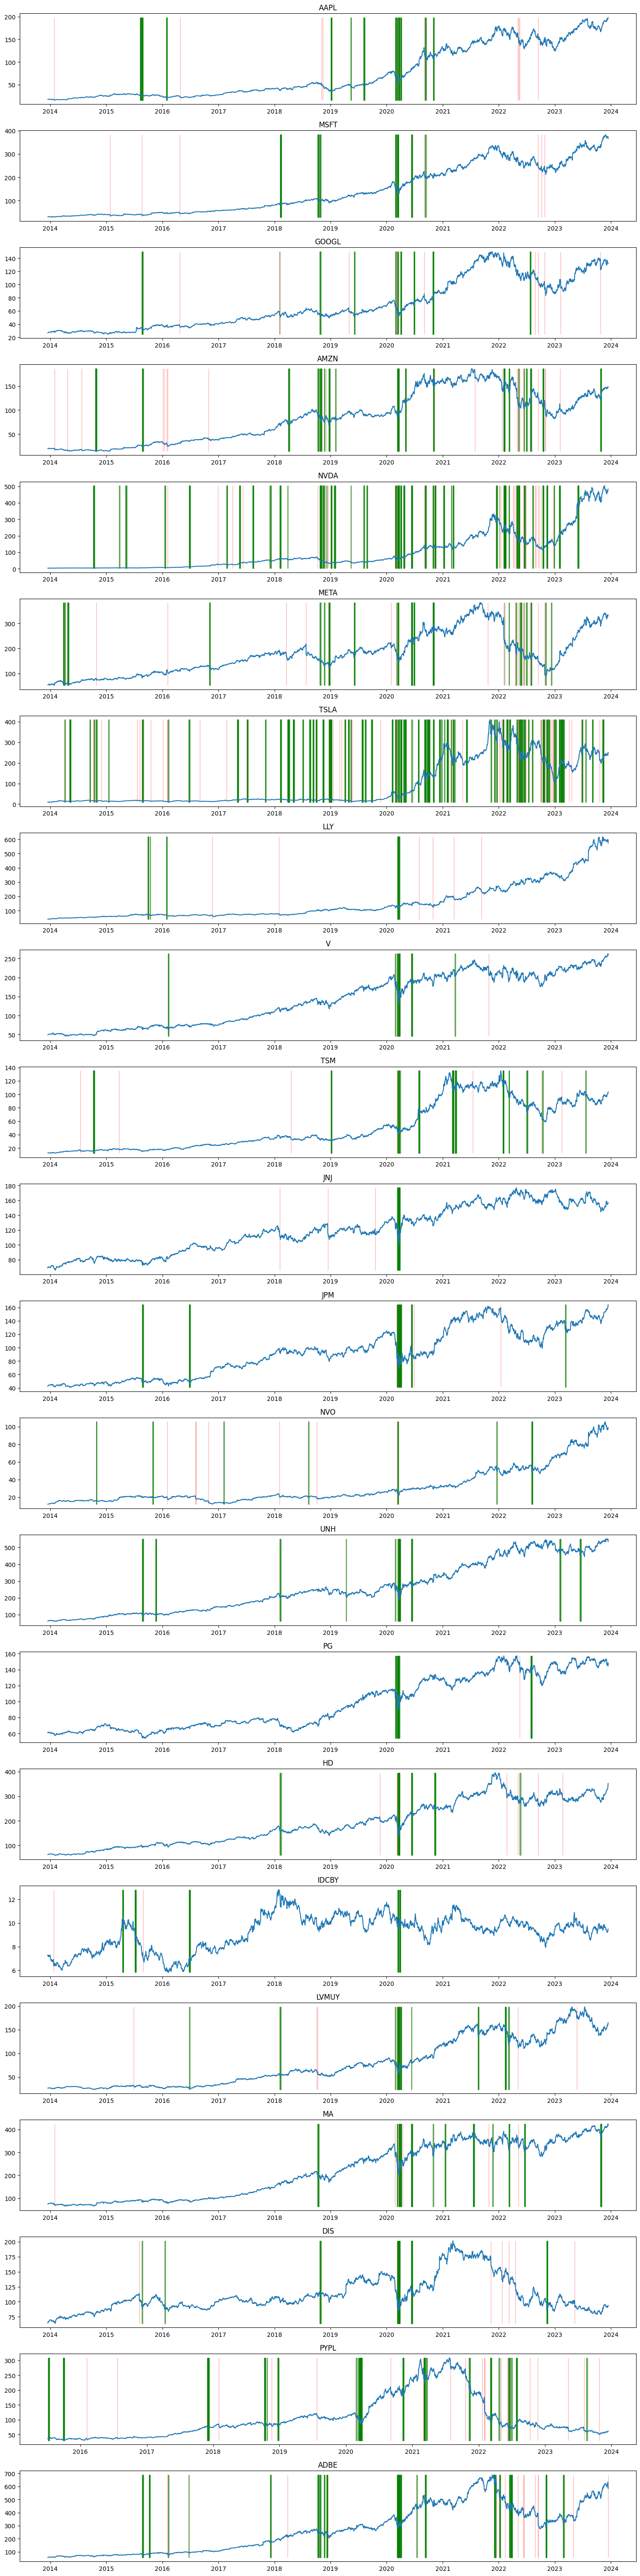

In [3]:
# Number of rows and columns for subplots
n_rows = 22
n_cols = 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 60)) # Increased figure height for better visibility

for i, stock in enumerate(stocks):
    # Select subplot
    ax = axes[i]
    
    # Fetch data for this stock
    df = all_data[stock]
    
    # Plot data
    ax.plot(df.index, df['Adj Close'])
    ax.set_title(stock)
    
    # Highlight days with a percentage change of -0.05 or lower
    ax.fill_between(df.index, df['Adj Close'].min(), df['Adj Close'].max(), 
                    where=(df['Return'] <= -0.05), color='red', alpha=0.3)

    # Check for each day with a drop of -0.05 or lower if there's a day in the next 7 days where the price went up by 2% or more compared to the lower value
    drop_days = df[df['Return'] <= -0.05].index
    for drop_day in drop_days:
        next_days = df.loc[drop_day:drop_day + pd.Timedelta(days=7)]
        if any(next_days['Adj Close'] > df.loc[drop_day, 'Adj Close'] * 1.02):
            increase_days = next_days[next_days['Adj Close'] > df.loc[drop_day, 'Adj Close'] * 1.02].index
            for increase_day in increase_days:
                ax.fill_between([drop_day, increase_day], df['Adj Close'].min(), df['Adj Close'].max(), color='green', alpha=0.5)

plt.tight_layout()
plt.show()

In [4]:
# Create a DataFrame for returns
returns_df = pd.DataFrame({stock: df['Return'] for stock, df in all_data.items()})

# Flatten the DataFrame into a single series
all_returns = returns_df.values.flatten()

# Remove NaN values
all_returns = all_returns[~np.isnan(all_returns)]

# Convert to a pandas Series
all_returns = pd.Series(all_returns)

# Get statistical summary
stats = all_returns.describe()

print(stats)

count    54936.000000
mean         0.000924
std          0.019438
min         -0.263901
25%         -0.007626
50%          0.000863
75%          0.009574
max          0.298067
dtype: float64


<Axes: >

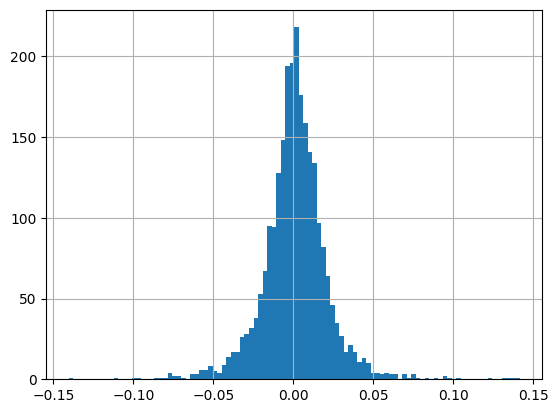

In [5]:
all_data['AMZN']['Return'].hist(bins=100)

In [ ]:
#every day evalute a list of preslected foundametnally promising stocks. find the ont that lost the most that day
#check if the lost beacuse of news and in case decide to buy them. 
#Aim for 2% profit in a week. 

In [35]:
import backtrader as bt

class MyStrategy(bt.Strategy):
    def next(self):
       # # Check if the S&P 500 index dropped today
       # sp500_change = (self.datas[0].close[0] - self.datas[0].open[0]) / self.datas[0].open[0]
       # if sp500_change < 0:
       #     return  # Do not buy any stocks if the S&P 500 dropped

        # Find all stocks that lost more than 5% since the previous day
        loss_stocks = [data for data in self.datas[1:] if (data.close[0] - data.open[0]) / data.open[0] <= -0.05]

        # Buy these stocks
        for data in loss_stocks:
            self.buy(data)

        # Check if any stock in the portfolio has reached 2% profit
        for data in self.datas[1:]:
            if self.getposition(data).size > 0 and data.close[0] > self.getposition(data).price * 2:
                self.sell(data)

In [86]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.buy_days = {}

    def next(self):
        # Find all stocks that lost more than 5% in a week
        loss_stocks = [data for data in self.datas if (data.close[0] - data.close[-1]) / data.close[-1] <= -0.02]

        # Buy these stocks and store the day they were bought
        for data in loss_stocks:
            self.buy(data)
            self.buy_days[data] = len(self)

        # Sell stocks that were bought a week ago
        for data in self.datas:
            if data in self.buy_days and len(self) >= self.buy_days[data] + 5:
                self.sell(data)
                del self.buy_days[data]

class TradeAnalysis(bt.Analyzer):
    def __init__(self):
        self.trades = defaultdict(lambda: {'won': 0, 'lost': 0, 'pnl': []})

    def notify_trade(self, trade):
        if trade.isclosed:
            year = self.strategy.datetime.date().year
            if trade.pnl > 0:
                self.trades[year]['won'] += 1
            else:
                self.trades[year]['lost'] += 1
            self.trades[year]['pnl'].append(trade.pnl)

    def get_analysis(self):
        return self.trades

# Add strategy to cerebro
cerebro.addstrategy(MyStrategy)

# Add the TimeReturn analyzer with a timeframe of Years
cerebro.addanalyzer(bt.analyzers.TimeReturn, timeframe=bt.TimeFrame.Years, _name='annualreturn')
cerebro.addanalyzer(TradeAnalysis, _name='tradeanalysis')

# Run the backtest
results = cerebro.run()

# Print the portfolio value at the end of each year
annual_returns = results[0].analyzers.annualreturn.get_analysis()
for year, return_value in annual_returns.items():
    print(f'Year: {year}, Return: {return_value}')

# Print the number of trades won or lost each year
trade_analysis = results[0].analyzers.tradeanalysis.get_analysis()
for year, trades in trade_analysis.items():
    print(f'Year: {year}, Trades won: {trades["won"]}, Trades lost: {trades["lost"]}')

# Print the Sharpe Ratio
print('Sharpe Ratio:', results[0].analyzers.sharpe.get_analysis())

Year: 2013, Return: 50000.0
Year: 2014, Return: 50000.0
Year: 2015, Return: 50000.0
Year: 2016, Return: 52730.56300640106
Year: 2017, Return: 59324.36342239379
Year: 2018, Return: 84925.30888271332
Year: 2019, Return: 84762.94251632692
Year: 2020, Return: 122271.84736633301
Year: 2021, Return: 342382.07743930805
Year: 2022, Return: 543253.9101057053
Year: 2023, Return: 213089.2472639084
Year: 2015, Trades won: 1, Trades lost: 2
Year: 2019, Trades won: 1, Trades lost: 0
Sharpe Ratio: OrderedDict([('sharperatio', 0.5690804111072463)])


In [88]:
from zipline.api import order_target, record, symbol
import pandas as pd

def initialize(context):
    context.hold_days = pd.Timedelta('7 days')
    context.pct_change_threshold = -0.05
    context.stocks_held = {}

def handle_data(context, data):
    # Buy stocks
    for stock in data:
        pct_change = data[stock].pct_change()
        if pct_change < context.pct_change_threshold:
            order_target(stock, 1)
            context.stocks_held[stock] = context.datetime

    # Sell stocks
    for stock in list(context.stocks_held.keys()):
        if context.datetime - context.stocks_held[stock] > context.hold_days:
            order_target(stock, 0)
            del context.stocks_held[stock]

    record(stocks_held=len(context.stocks_held))

ModuleNotFoundError: No module named 'zipline'

In [94]:
# Define the assets you want to backtest on
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 
          'TSLA', 'LLY', 'V', 'TSM', 'JNJ', 'JPM', 'NVO', 
          'UNH', 'PG', 'HD', 'IDCBY', 'LVMUY', 'MA', 'DIS', 
          'PYPL', 'ADBE']

# Download the price data
data = yf.download(stocks, start='2010-01-01', end='2020-12-31')

# Use only the Adjusted Close prices
data = data['Adj Close']

print(data.head())

[*********************100%%**********************]  22 of 22 completed
                AAPL       ADBE    AMZN        DIS      GOOGL         HD  \
Date                                                                       
2010-01-04  6.478998  37.090000  6.6950  27.843180  15.684434  20.551077   
2010-01-05  6.490198  37.700001  6.7345  27.773720  15.615365  20.701616   
2010-01-06  6.386964  37.619999  6.6125  27.626129  15.221722  20.629929   
2010-01-07  6.375155  36.889999  6.5000  27.634809  14.867367  20.873652   
2010-01-08  6.417541  36.689999  6.6760  27.678221  15.065566  20.773291   

            IDCBY        JNJ        JPM        LLY  ...  META       MSFT  \
Date                                                ...                    
2010-01-04    NaN  42.974457  29.852806  23.817675  ...   NaN  23.474918   
2010-01-05    NaN  42.476135  30.431046  23.398771  ...   NaN  23.482500   
2010-01-06    NaN  42.821632  30.598242  23.571655  ...   NaN  23.338394   
2010-01-07    Na

In [98]:
import bt
import pandas as pd

def strategy(data):
    # Define the hold days and pct change threshold
    hold_days = pd.Timedelta('7 days')
    pct_change_threshold = -0.05

    # Create a dictionary to hold the stocks
    stocks_held = {}

    # Iterate over the columns of the data DataFrame
    for stock in data.columns:
        # Calculate the percent change
        pct_change = data[stock].pct_change()

        # Buy stocks
        if (pct_change < pct_change_threshold).any():
            data[stock] = 1
            stocks_held[stock] = data.index[-1]

        # Sell stocks
        if stock in stocks_held and data.index[-1] - stocks_held[stock] > hold_days:
            data[stock] = 0
            del stocks_held[stock]

    return data

In [101]:
# Create the DataFrame of target weights
target_weights = strategy(data)

# Create the WeighTarget algorithm
weigh_target = bt.algos.WeighTarget(target_weights)

# Create the strategy
bt_strategy = bt.Strategy('MyStrategy', [weigh_target, bt.algos.Rebalance()])

# Create a backtest and run it
test = bt.Backtest(bt_strategy, data)
res = bt.run(test)

# Print the total value of the portfolio over time
print(res.prices)

# Print the number of shares held in each asset over time
#print(res.positions)

# Print information about each transaction
#print(res.transactions)

# Print statistics about the backtest
print(res.stats)

            MyStrategy
2010-01-03       100.0
2010-01-04       100.0
2010-01-05       100.0
2010-01-06       100.0
2010-01-07       100.0
...                ...
2020-12-23       100.0
2020-12-24       100.0
2020-12-28       100.0
2020-12-29       100.0
2020-12-30       100.0

[2769 rows x 1 columns]
                                MyStrategy
start                  2010-01-03 00:00:00
end                    2020-12-30 00:00:00
rf                                     0.0
total_return                           0.0
cagr                                   0.0
max_drawdown                           0.0
calmar                                 NaN
mtd                                    0.0
three_month                            0.0
six_month                              0.0
ytd                                    0.0
one_year                               0.0
three_year                             0.0
five_year                              0.0
ten_year                               0.0
incep      

/Users/giacomo/.pyenv/versions/3.9.7/envs/stocks/lib/python3.9/site-packages/ffn/core.py:1258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_prices[-1] / monthly_prices[-2] - 1
/Users/giacomo/.pyenv/versions/3.9.7/envs/stocks/lib/python3.9/site-packages/ffn/core.py:1270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return daily_prices[-1] / yearly_prices[-2] - 1
/Users/giacomo/.pyenv/versions/3.9.7/envs/stocks/lib/python3.9/site-packages/ffn/core.py:232: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consist